In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import datetime
import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
#csvのパスを設定
csv_path = "C:\\Users\\meida\\lab_materials\\M1\\pems\\data\\integrated_route.csv"

In [3]:
df = pd.read_csv(csv_path,index_col=0)
# Slice [start:stop:step], starting from index 5 take every 6th record.
#df = df[5::6]
df = df.dropna(axis=1)
date_time = pd.to_datetime(df.pop('5 Minutes'), format='%Y.%m.%d %H:%M:%S')

In [4]:
target = "6640"

In [5]:
df

,11750,13147,13867,14467,14987,16207,16507,16509,16510,16511,...,79,80,81,82,83,84,85,86,87,88
0,17.12,35.00,8.68,20.38,7.20,21.45,31.12,30.18,36.07,40.50,...,30.03,29.03,36.18,36.57,11.90,11.88,16.75,16.68,15.48,12.27
1,17.05,35.05,8.73,20.73,7.20,21.63,31.23,30.33,35.88,40.30,...,30.00,29.30,35.83,36.82,11.88,11.92,16.70,16.85,15.85,12.22
2,16.87,35.03,8.68,20.23,7.22,21.42,31.05,30.27,35.92,40.35,...,30.07,29.22,35.78,37.38,11.83,12.03,16.68,16.88,15.93,12.22
3,16.88,34.93,8.65,20.00,7.23,21.37,31.13,30.32,35.92,40.35,...,30.23,29.10,35.90,37.47,11.80,11.98,16.68,16.83,15.85,12.17
4,16.93,34.77,8.63,20.08,7.27,21.27,30.93,30.17,36.03,40.58,...,30.35,29.18,36.07,36.65,11.78,12.02,16.67,16.90,15.65,12.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25567,17.15,35.30,8.60,19.42,7.22,21.57,30.62,30.30,36.15,40.72,...,30.65,30.08,36.03,36.00,11.78,12.03,16.82,17.02,15.52,12.78
25568,17.10,35.30,8.58,19.47,7.23,21.57,30.87,30.37,36.02,40.62,...,30.68,30.13,35.95,36.07,11.78,12.05,16.90,17.10,15.73,12.87
25569,17.32,35.28,8.60,19.43,7.22,21.82,31.45,31.00,36.17,40.82,...,30.52,30.03,36.02,35.98,11.82,12.00,16.87,17.17,15.63,12.78
25570,17.25,35.32,8.65,19.48,7.23,21.73,31.73,31.43,36.13,40.70,...,30.67,29.90,35.97,36.03,11.82,12.07,16.90,17.65,15.82,12.83


In [6]:
test_labels = df[int(len(df)*0.9):].loc[:,[target]]

In [7]:
df.head()

,11750,13147,13867,14467,14987,16207,16507,16509,16510,16511,...,79,80,81,82,83,84,85,86,87,88
0,17.12,35.00,8.68,20.38,7.20,21.45,31.12,30.18,36.07,40.50,...,30.03,29.03,36.18,36.57,11.90,11.88,16.75,16.68,15.48,12.27
1,17.05,35.05,8.73,20.73,7.20,21.63,31.23,30.33,35.88,40.30,...,30.00,29.30,35.83,36.82,11.88,11.92,16.70,16.85,15.85,12.22
2,16.87,35.03,8.68,20.23,7.22,21.42,31.05,30.27,35.92,40.35,...,30.07,29.22,35.78,37.38,11.83,12.03,16.68,16.88,15.93,12.22
3,16.88,34.93,8.65,20.00,7.23,21.37,31.13,30.32,35.92,40.35,...,30.23,29.10,35.90,37.47,11.80,11.98,16.68,16.83,15.85,12.17
4,16.93,34.77,8.63,20.08,7.27,21.27,30.93,30.17,36.03,40.58,...,30.35,29.18,36.07,36.65,11.78,12.02,16.67,16.90,15.65,12.22


In [8]:
#相関係数0.8以上（11個）
#df = df.loc[:,['11750', '18828', '18830', '275', '4649', '4651', '6224', '6225', '78','79', '81']]

#近くの経路（96個）
#df = df.loc[:,['11750', "4649","79","6225","18830","81","275","78","18828","6224","19835","2132","14467","4648","77","82","80","372","19837","6670","86","6218","6221","271","6679","18862","18846","85","6680","18860","6215","274","13867","18852","276","2135","6220","6202","365","6678","366","413","359","18820","88","379","16207","360","6701","6669","6203","19979","367","6216","6616","6700","6662","6214","272","361","6606","2131","2134","363","18822","87","6665","22622","6200","6666","18850","6217","18832","6671","6604","6605","6219","6663","3394","19981","6201","6601","6675","362","18854","18856","18834","6600","6603","6602","6705","6664","6615","6674","6673","18858"]]

#相関係数0.7以上（77個）
#df = df.loc[:,['11750', '13147', '13867', '14467', '16507', '16509', '16510', '16511','18174', '18824', '18828', '18830', '18836', '18838', '18840', '18846','18852', '18860', '18862', '18868', '18872', '19835', '19837', '19839','19955', '20274', '2132', '2133', '2135', '271', '274', '275', '276','358', '365', '366', '369', '372', '373', '412', '425', '434', '4647','4648', '4649', '4650', '4651', '471', '571', '6202', '6210', '6212', '6215', '6218', '6220', '6221', '6222', '6224', '6225', '6226', '6227','6641', '6670', '6677', '6678', '6679', '6680', '6723', '77', '78','79', '80', '81', '82', '83', '85', '86']]

#ＤＴＷで11個選ぶ
#df = df.loc[:,['11750','4649','79','6225','18830','6224','18828','81','18174','4651','16507']]

#df = df.loc[:,["11750"]]

In [9]:
df.describe()

,11750,13147,13867,14467,14987,16207,16507,16509,16510,16511,...,79,80,81,82,83,84,85,86,87,88
count,80100.000000,80100.000000,80100.000000,80100.000000,80100.000000,80100.00000,80100.000000,80100.000000,80100.000000,80100.000000,...,80100.000000,80100.000000,80100.000000,80100.000000,80100.000000,80100.000000,80100.000000,80100.000000,80100.000000,80100.000000
mean,19.170902,39.101017,12.192407,23.518934,8.058261,24.52464,35.859563,35.072517,40.535897,45.218016,...,33.772151,33.001722,43.713114,40.960143,15.940215,14.125292,20.698876,21.033284,17.723159,14.774022
std,3.040124,5.006690,5.371723,4.789279,1.710866,3.92402,6.242558,5.497627,6.962691,7.069311,...,4.156159,4.339530,9.720439,6.230415,6.191741,2.696299,4.576538,4.895500,3.176840,4.458063
min,15.880000,33.600000,8.280000,18.550000,6.700000,20.45000,29.330000,28.520000,34.600000,38.880000,...,28.680000,27.630000,34.620000,34.420000,11.370000,11.430000,15.900000,15.770000,14.120000,11.420000
25%,17.120000,35.420000,8.650000,19.650000,7.130000,21.75000,31.500000,30.770000,36.320000,40.820000,...,30.620000,29.780000,36.630000,36.300000,11.830000,12.050000,17.150000,17.150000,15.850000,12.400000
50%,17.970000,36.770000,9.770000,21.630000,7.450000,22.67000,33.200000,32.930000,37.870000,42.500000,...,32.230000,31.500000,38.830000,38.330000,13.420000,12.900000,18.730000,18.820000,16.530000,13.070000
75%,20.230000,41.580000,13.000000,26.070000,8.020000,26.38000,38.130000,37.650000,41.520000,46.430000,...,35.950000,34.750000,48.420000,44.080000,16.880000,15.630000,23.070000,23.770000,18.200000,14.500000
max,51.480000,79.430000,34.630000,52.800000,33.400000,55.18000,77.100000,70.670000,86.000000,92.120000,...,72.930000,62.520000,94.100000,84.730000,44.630000,27.850000,57.880000,72.030000,62.080000,79.950000


C:\Users\meida\anaconda3\envs\tensorflow-gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


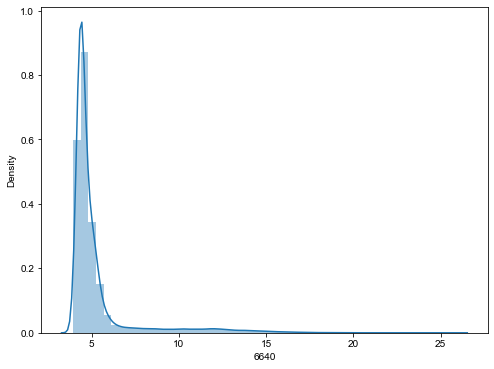

In [10]:
sns.distplot(df[target])
sns.set()

from sklearn.preprocessing import MinMaxScaler, PowerTransformer
#mm = MinMaxScaler()
pt = PowerTransformer(standardize=False)
#df[:] = mm.fit_transform(df)
df[:] = pt.fit_transform(df)

df

sns.distplot(df['11750'])
sns.set()

plot_cols = ['11750', '18828', '18830', '275', '4649', '4651', '6224', '6225', '78','79', '81']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

df.describe().transpose()

timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

fft = tf.signal.rfft(df['11750'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['11750'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 50000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

C:\Users\meida\anaconda3\envs\tensorflow-gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


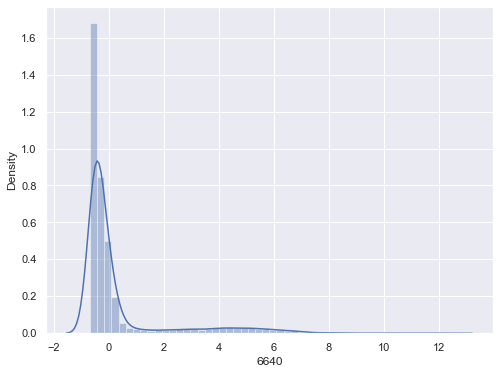

In [13]:
sns.distplot(test_df[target])
sns.set()

## yeojonson変換

In [15]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
#mm = MinMaxScaler()
train_pt = PowerTransformer(standardize=False)
val_pt = PowerTransformer(standardize=False)
test_pt = PowerTransformer(standardize=False)

#df[:] = mm.fit_transform(df)
train_df[:] = train_pt.fit_transform(train_df)
val_df[:] = val_pt.fit_transform(val_df)
test_df[:] = test_pt.fit_transform(test_df)

C:\Users\meida\anaconda3\envs\tensorflow-gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


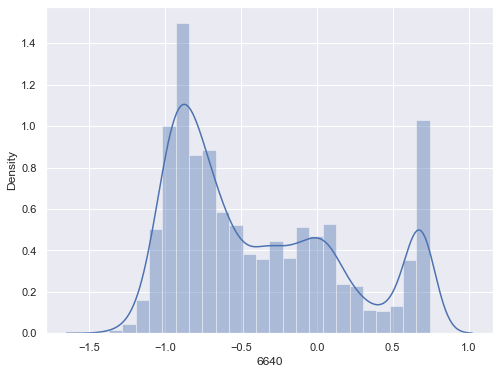

In [16]:
sns.distplot(test_df[target])
sns.set()

In [17]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
#plt.figure(figsize=(12, 6))
#ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
#_ = ax.set_xticklabels(df.keys(), rotation=90)

In [18]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [19]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=[target])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['6640']

In [20]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=[target])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['6640']

In [21]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [22]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 272)
Inputs shape: (3, 6, 272)
Labels shape: (3, 1, 1)


In [23]:
w2.example = example_inputs, example_labels

In [24]:
def plot(self, model=None, plot_col=target, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('5 Minutes')

WindowGenerator.plot = plot

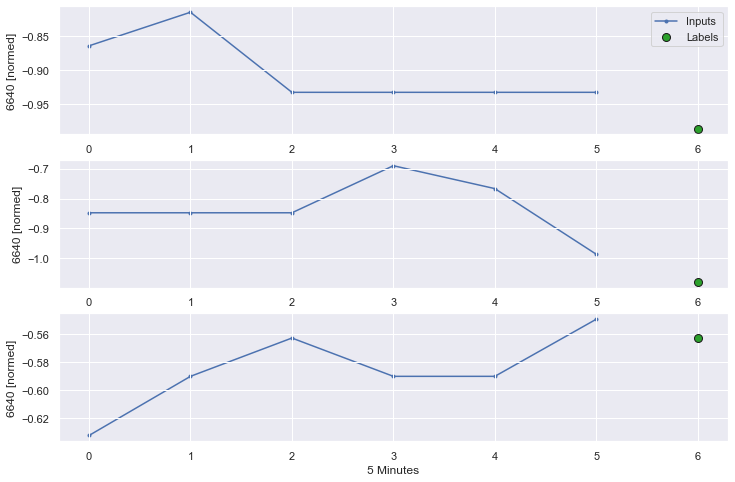

In [25]:
w2.plot()

In [26]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [27]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [28]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 272), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [29]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 272)
Labels shape (batch, time, features): (32, 1, 1)


In [30]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[target])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['6640']

In [31]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 272)
Labels shape (batch, time, features): (32, 1, 1)


In [32]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [33]:
baseline = Baseline(label_index=column_indices[target])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

501/501 [==============================] - 1s 1ms/step - loss: 0.0071 - root_mean_squared_error: 0.0842


In [34]:
wide_window = WindowGenerator(
    input_width=12, label_width=12, shift=1,
    label_columns=[target])

wide_window

Total window size: 13
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Label column name(s): ['6640']

In [35]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 12, 272)
Output shape: (32, 12, 1)


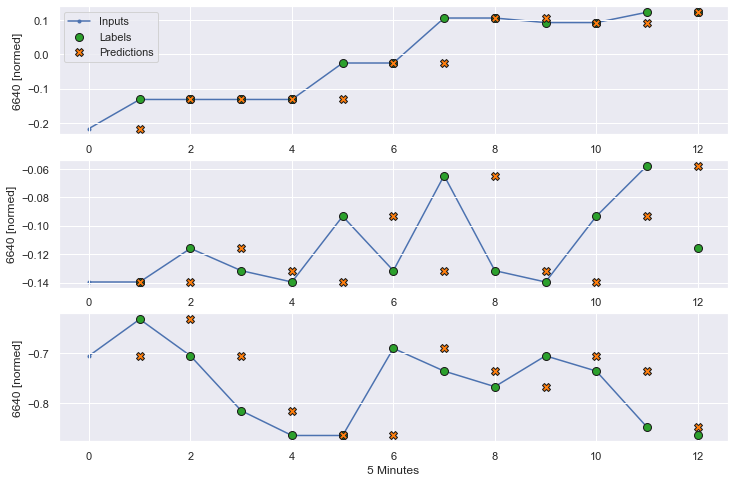

In [36]:
wide_window.plot(baseline)

In [37]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [38]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 272)
Output shape: (32, 1, 1)


In [39]:
MAX_EPOCHS = 40

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.metrics.MeanSquaredError(),tf.metrics.MeanAbsoluteError()])
                #metrics=[tf.metrics.MeanAbsoluteError()])

  start = time.time()
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping]
                     )
  run_time = time.time() - start
  return history,run_time

In [40]:
history,run_time= compile_and_fit(linear, single_step_window)
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/40
1753/1753 [==============================] - 6s 3ms/step - loss: 0.1056 - root_mean_squared_error: 0.3250 - mean_squared_error: 0.1056 - mean_absolute_error: 0.2086 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1713 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1328
Epoch 2/40
1753/1753 [==============================] - 5s 3ms/step - loss: 0.0116 - root_mean_squared_error: 0.1078 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0814 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0838
Epoch 3/40
1753/1753 [==============================] - 5s 3ms/step - loss: 0.0075 - root_mean_squared_error: 0.0868 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0638 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0966 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0722
Epoch 4/40
1753/1753 [==============================] - 6s 3ms/step - loss: 0.0065 - root_mean_squar

In [41]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 12, 272)
Output shape: (32, 12, 1)


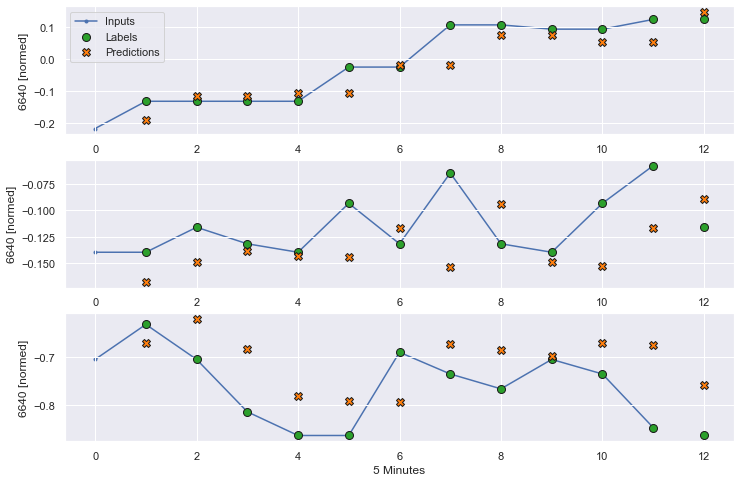

In [42]:
wide_window.plot(linear)

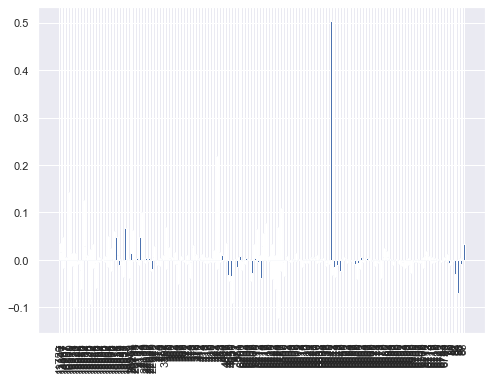

In [43]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history,run_time = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[target])

conv_window

conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

history,run_time = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

conv_window.plot(multi_step_dense)

print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

LSTM

In [44]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    #tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=False,kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    #tf.keras.layers.Dense(units=64, activation='relu'),
    #tf.keras.layers.Dense(units=32, activation='relu'),
    #tf.keras.layers.Dense(units=32, activation='relu'),
    #tf.keras.layers.Dense(units=1, activation='relu'),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [45]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 12, 272)
Output shape: (32, 1)


In [46]:
history,run_time = compile_and_fit(lstm_model, wide_window)
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
print(run_time)

501/501 [==============================] - 1s 3ms/step - loss: 0.0150 - root_mean_squared_error: 0.1211 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0834
74.67839527130127


### return_sequences=Trueにするとプロットできる

wide_window.plot(lstm_model)

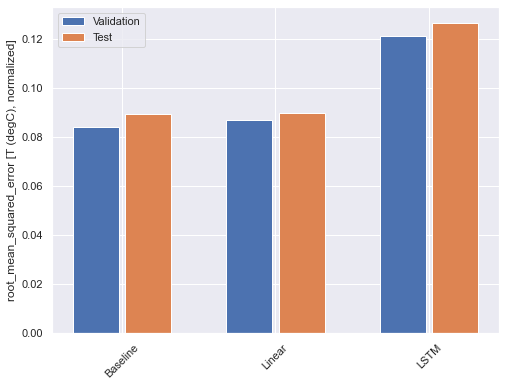

In [47]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'root_mean_squared_error'
metric_index = lstm_model.metrics_names.index('root_mean_squared_error')
#metric_name = 'mean_absolute_error'
#metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('root_mean_squared_error [T (degC), normalized]')
#plt.ylabel('mean_absolute_error [T (degC), normalized]')

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [48]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0896
Linear      : 0.0898
LSTM        : 0.1266


In [49]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                86272     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 86,337
Trainable params: 86,337
Non-trainable params: 0
_________________________________________________________________


In [50]:
lstm_model.predict(wide_window.test).shape

(7998, 1)

## 逆変換

test_df[:] = pt.inverse_transform(test_df)
#test_df[:] = mm.inverse_transform(test_df)

In [51]:
normed_prediction = lstm_model.predict(wide_window.test).flatten()
test_df[target][12:] = normed_prediction
test_df[:] = test_pt.inverse_transform(test_df)
test_df[target] = test_df[target]*train_std[target]+train_mean[target]

## baseline

normed_prediction = baseline.predict(single_step_window.test).flatten()
test_df[target][1:] = normed_prediction
#test_df[:] = test_pt.inverse_transform(test_df)
test_df[target] = test_df[target]*train_std[target]+train_mean[target]

In [52]:
test_df

,11750,13147,13867,14467,14987,16207,16507,16509,16510,16511,...,79,80,81,82,83,84,85,86,87,88
17562,-0.468721,0.010692,-0.582104,-0.567942,-0.277880,-0.229562,-0.254817,-0.394674,-0.394706,-0.387202,...,-0.328284,-0.463159,-0.162018,0.377462,-0.579549,-0.464733,0.507254,-0.400412,-0.146598,-0.362559
17563,-0.457184,0.013085,-0.576345,-0.535029,-0.237978,-0.303910,-0.200314,-0.317138,-0.403157,-0.387202,...,-0.347400,-0.436025,-0.096950,0.261364,-0.582983,-0.425989,0.310965,-0.426672,-0.034329,-0.308867
17564,-0.418728,0.037014,-0.576345,-0.506504,-0.224677,-0.318779,-0.256634,-0.330707,-0.364284,-0.370557,...,-0.306439,-0.349197,-0.052075,0.256005,-0.582983,-0.398867,0.016531,-0.415730,-0.002893,-0.322873
17565,-0.407192,-0.018024,-0.576345,-0.473591,-0.271230,-0.330675,-0.242100,-0.353967,-0.350763,-0.367228,...,-0.284593,-0.286790,-0.083487,0.184561,-0.570965,-0.398867,-0.157675,-0.406977,-0.079236,-0.343883
17566,-0.399501,-0.065883,-0.576345,-0.451649,-0.244628,-0.274171,-0.209398,-0.311323,-0.359213,-0.367228,...,-0.216324,0.006254,-0.153043,0.063105,-0.570965,-0.379495,-0.182211,-0.393846,-0.088218,-0.285522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25567,-0.649462,-0.735915,-0.662744,-0.842219,-0.477391,-0.720255,-0.874331,-0.873454,-0.634707,-0.641870,...,-0.729703,-0.658521,-0.755488,-0.762082,-0.668827,-0.774693,-0.820150,-0.811826,-0.766326,-0.413917
25568,-0.668690,-0.735915,-0.666584,-0.831248,-0.470741,-0.720255,-0.828912,-0.859886,-0.656679,-0.658515,...,-0.721511,-0.644954,-0.764463,-0.749579,-0.668827,-0.766944,-0.800521,-0.794319,-0.672020,-0.392907
25569,-0.584087,-0.740701,-0.662744,-0.840025,-0.477391,-0.645907,-0.723540,-0.737768,-0.631327,-0.625225,...,-0.765203,-0.672088,-0.756610,-0.765654,-0.661960,-0.786316,-0.807882,-0.779001,-0.716928,-0.413917
25570,-0.611006,-0.731129,-0.653144,-0.829054,-0.470741,-0.672672,-0.672671,-0.654417,-0.638087,-0.645199,...,-0.724242,-0.707362,-0.762219,-0.756723,-0.661960,-0.759195,-0.800521,-0.673959,-0.631603,-0.402245


In [53]:
test_labels

,6640
17562,4.72
17563,4.70
17564,4.92
17565,5.03
17566,4.98
...,...
25567,4.15
25568,4.23
25569,4.13
25570,4.15


In [54]:
test_predictions = test_df.loc[:,target]

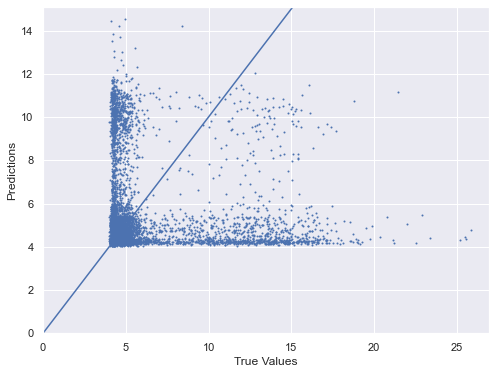

In [55]:
plt.scatter(test_labels, test_predictions,s=1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
#plt.axis('equal')
#plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

InvalidIndexError: (slice(None, None, None), None)

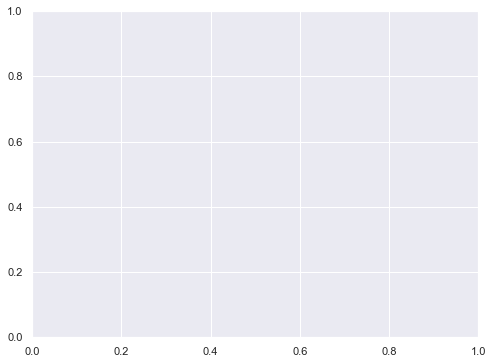

In [56]:
plt.plot([i for i in range(200)],test_labels[1500:1700],color="red")
plt.plot([i for i in range(200)],test_predictions[1500:1700],color="blue")
plt.show()

In [ ]:
plt.plot([i for i in range(200)],test_labels[3500:3700],color="red")
plt.plot([i for i in range(200)],test_predictions[3500:3700],color="blue")
plt.show()

In [ ]:
plt.plot([i for i in range(200)],test_labels[5500:5700],color="red")
plt.plot([i for i in range(200)],test_predictions[5500:5700],color="blue")
plt.show()

In [ ]:
def plot_history(histories, key='mean_squared_error'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([("LSTM", history)])

single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

# ユークリッド距離

In [ ]:
df = pd.read_csv(csv_path,index_col=0)
# Slice [start:stop:step], starting from index 5 take every 6th record.
#df = df[5::6]
df = df.dropna(axis=1)
date_time = pd.to_datetime(df.pop('5 Minutes'), format='%Y.%m.%d %H:%M:%S')

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
plot_cols = ['11750', '18828', '18830', '275', '4649', '4651', '6224', '6225', '78','79', '81']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [ ]:
df_std = (df - train_mean) / train_std

In [ ]:
df_std

In [ ]:
from scipy.spatial import distance
dict_dist={}
for i in df.columns:
    dist = distance.euclidean(df_std.loc[:,["11750"]], df_std.loc[:,[i]])
    dict_dist[i]=dist
dict_dist = sorted(dict_dist.items(), key=lambda x:x[1])[:11]
dict_dist

# DTW

In [ ]:
##### import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from matplotlib import pyplot as plt
dict_DTW = {}
# 異なる2種類のデータを定義
for i in df.columns:
    x = np.array(df_std.loc[:,["11750"]].values).reshape(-1, 1)
    y = np.array(df_std.loc[:,[i]].values).reshape(-1, 1)
    # DTWを計算
    distance, path = fastdtw(x, y, dist=euclidean)
    dict_DTW[i] = distance
dict_DTW = sorted(dict_DTW.items(), key=lambda x:x[1])[:11]
dict_DTW